## A tour of MLJ

### Models, machines, basic training and testing

Let's load data and define train and test rows:

In [39]:
using MLJ
using DataFrames, Statistics

Xraw = rand(300,3)
y = exp(Xraw[:,1] - Xraw[:,2] - 2Xraw[:,3] + 0.1*rand(300))
X = DataFrame(Xraw)

train, test = partition(eachindex(y), 0.70); # 70:30 split

A *model* is a container for hyperparameters:

In [2]:
knn_model=KNNRegressor(K=10)

KNNRegressor(target_type = Float64,
             K = 10,
             metric = MLJ.KNN.euclidean,
             kernel = MLJ.KNN.reciprocal,) @ 2…26

Wrapping the model in data creates a *machine* which will store training outcomes.

In [3]:
knn = machine(knn_model, X, y)

Machine @ 2…86


Training on the training rows and evaluating on the test rows:

In [4]:
fit!(knn, rows=train)
yhat = predict(knn, X[test,:])
rms(yhat, y[test])

┌ Info: Training Machine @ 2…86.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115


0.12853140928320453

Or, we could have skipped the train/test definitions and evaluated one line:

In [5]:
evaluate!(knn, resampling=Holdout(fraction_train=0.7), measure=rms)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.7 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


0.12853140928320453

Our machine/model constructions and associateed fit/predict syntax anticipates a powerful extension for building networks of learners described later. Changing a hyperparameter and re-evaluating:

In [6]:
knn_model.K = 20
evaluate!(knn, resampling=Holdout(fraction_train=0.7))  # `default_measure(knn) == rms` so `measure` kwarg can be dropped

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.7 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:91


0.15618555765353453

### Homogeneous ensembles

Here's a bagged ensemble model for 20 K-nearest neighbour regressors:

In [7]:
ensemble_model = EnsembleModel(atom=knn_model, n=20)

MLJ.DeterministicEnsembleModel(atom = KNNRegressor @ 2…26,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x3e5b42d3, 0xc66a5ccd, 0x57ccde19, 0x1bbc369f]),
                               n = 20,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 9…05

In [8]:
@more

MLJ.DeterministicEnsembleModel(atom = KNNRegressor(target_type = Float64,
                                                   K = 20,
                                                   metric = MLJ.KNN.euclidean,
                                                   kernel = MLJ.KNN.reciprocal,),
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x3e5b42d3, 0xc66a5ccd, 0x57ccde19, 0x1bbc369f]),
                               n = 20,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 9…05

It can be trained and tested the same as any other model:

In [9]:
ensemble = machine(ensemble_model, X, y)
estimates = evaluate!(ensemble, resampling=CV())

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:135
Cross-validating: 100%[=========================] Time: 0:00:04


6-element Array{Float64,1}:
 0.1540634261614765  
 0.06131594097434255 
 0.12431277342613434 
 0.056901727300418634
 0.1129447261633142  
 0.16218266101438011 

In [10]:
mean(estimates)

0.11195354250667773

### Systematic tuning

Let's simultaneously tune the ensemble's `bagging_fraction` and the K-nearest neighbour hyperparameter `K`. Since one of our models is a field of the other, we have nested hyperparameters:

In [11]:
params(ensemble_model) # extract model hyperparameters as nested named tuple

(atom = (target_type = Float64,
         K = 20,
         metric = MLJ.KNN.euclidean,
         kernel = MLJ.KNN.reciprocal,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x3e5b42d3, 0xc66a5ccd, 0x57ccde19, 0x1bbc369f]),
 n = 20,
 parallel = true,
 out_of_bag_measure = Any[],)

To define a tuning grid, we construct ranges for the two parameters and collate these ranges following the same pattern above (omitting parameters that don't change):

In [12]:
B_range = range(ensemble_model, :bagging_fraction, lower= 0.5, upper=1.0, scale = :linear)
K_range = range(knn_model, :K, lower=1, upper=100, scale=:log10)
nested_ranges = (atom = (K = K_range,), 
                 bagging_fraction = B_range)

(atom = (K = NumericRange{K} @ 1…42,),
 bagging_fraction = NumericRange{bagging_fraction} @ 3…05,)

Now we choose a tuning strategy:

In [13]:
tuning = Grid(resolution=12)

Grid(resolution = 12,
     parallel = true,) @ 8…22

And a resampling strategy:

In [14]:
resampling = Holdout(fraction_train=0.8)

Holdout(fraction_train = 0.8,
        shuffle = false,) @ 1…81

And define a new model which wraps the these strategies around our ensemble model:

In [15]:
tuned_ensemble_model = TunedModel(model=ensemble_model, 
    tuning=tuning, resampling=resampling, nested_ranges=nested_ranges)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel @ 9…05,
                            tuning = Grid @ 8…22,
                            resampling = Holdout @ 1…81,
                            measure = nothing,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (K = NumericRange{K} @ 1…42,), bagging_fraction = NumericRange{bagging_fraction} @ 3…05),
                            minimize = true,
                            full_report = true,) @ 8…06

Fitting the corresponding machine tunes the underlying model (in this case an ensemble) and retrains on all supplied data:

In [16]:
tuned_ensemble = machine(tuned_ensemble_model, X[train,:], y[train])
fit!(tuned_ensemble);

┌ Warning: No measure specified. Using measure=MLJ.rms. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:104
┌ Info: Training Machine @ 1…58.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115
Iterating over a 132-point grid: 100%[=========================] Time: 0:00:06
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/tuning.jl:179


For each fitted machine, one may inspect a user-friendly version of the fitted parameters (as opposed to the hyperparameters stored in its model). In the current case this is the best ensemble model (trained on all available data):

In [17]:
fitted_params(tuned_ensemble)

(best_model = DeterministicEnsembleModel @ 3…07,)

In [18]:
ans.best_model |> params

(atom = (target_type = Float64,
         K = 4,
         metric = MLJ.KNN.euclidean,
         kernel = MLJ.KNN.reciprocal,),
 weights = Float64[],
 bagging_fraction = 0.8636363636363636,
 rng = MersenneTwister(UInt32[0x3e5b42d3, 0xc66a5ccd, 0x57ccde19, 0x1bbc369f]),
 n = 20,
 parallel = true,
 out_of_bag_measure = Any[],)

The `report` method gives more detail on the tuning process:

In [19]:
report(tuned_ensemble) 

(parameter_names = ["atom.K" "bagging_fraction"],
 parameter_scales = Symbol[:log10 :linear],
 parameter_values = Any[1 0.5; 2 0.5; … ; 66 1.0; 100 1.0],
 measurements = [0.0718745, 0.0660446, 0.06871, 0.071838, 0.0702845, 0.0755318, 0.0827372, 0.101599, 0.125313, 0.16274  …  0.070628, 0.065686, 0.0660806, 0.0689687, 0.0723638, 0.0714392, 0.074366, 0.0877627, 0.108137, 0.137101],
 best_measurement = 0.06467637213165063,)

Or for a plot of tuning results:

┌ Info: Recompiling stale cache file /Users/anthony/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/anthony/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:935
└ @ Plots /Users/anthony/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:935
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:937
└ @ Plots /User

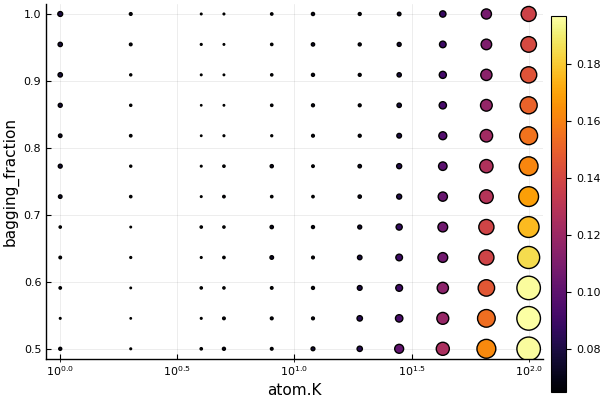

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _update_plot_object(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1314
└ @ Plots /Users/anthony/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1314
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /Users/anthony/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1343
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /Users/anthony/.julia/packages/Plots/gylTh/src/backends/

In [20]:
using Plots
pyplot()
plot(tuned_ensemble)

Evaluating the model:

In [21]:
yhat = predict(tuned_ensemble, X[test,:])
rms(yhat, y[test])

0.09603018481782859

Or, using all the data, get cross-validation estimates, with cv-tuning on each fold complement (nested resampling):

In [22]:
tuned_ensemble = machine(tuned_ensemble_model, X, y)
estimates = evaluate!(tuned_ensemble, resampling=CV(nfolds=4), verbosity=2)

┌ Info: Evaluating using cross-validation. 
│ nfolds=4. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/resampling.jl:135
Cross-validating:  20%[=====>                   ]  ETA: 0:00:00┌ Info: Training Machine @ 8…55.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115
Iterating over a 132-point grid: 100%[=========================] Time: 0:00:07
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/tuning.jl:179
Cross-validating:  40%[==========>              ]  ETA: 0:00:14┌ Info: Training Machine @ 8…55.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115
Iterating over a 132-point grid: 100%[=========================] Time: 0:00:06
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/tuning.jl:179
Cross-validating:  60%[===============>         ]  ETA: 0:00:10┌ Info

4-element Array{Float64,1}:
 0.0995783460072341 
 0.07730920590113027
 0.05052575931419724
 0.10821286146187001

In [23]:
mean(estimates)

0.0839065431711079

### Learning networks

MLJ has a flexible interface for building networks from multiple machine learning elements, whose complexity extend beyond linear "pipelines", and with a minimal of added abstraction.

In MLJ, a *learning network* is a graph whose nodes apply an operation, such as `predict` or `transform`, using a fixed machine (requiring training) - or which, alternatively, applies a regular (untrained) mathematical operation to its input(s). In practice, a learning network works with *fixed* sources for its training/evaluation data, but can be built and tested in stages. By contrast, an *exported learning network* is a learning network exported as a stand-alone, re-usable `Model` object, to which all the MLJ `Model`  meta-algorthims can be applied (ensembling, systematic tuning, etc). 

As we shall see, exporting a learning network as a reusable model, is very easy. 

### Building a simple learning network

![](wrapped_ridge.png)

The diagram above depicts a learning network which standardises the input data, `X`, learns an optimal Box-Cox transformation for the target, `y`, predicts new targets using ridge regression, and then inverse-transforms those predictions (for later comparison with the original test data). The machines are labelled yellow. 

To implement the network, we begin by loading all data needed for training and evaluation into *source nodes*:

In [24]:
Xs = source(X)
ys = source(y)

Source @ 2…36

We label nodes according to their outputs in the diagram. Notice that the nodes `z` and `yhat` use the same machine `box` for different operations. 

To construct the `W` node we first need to define the machine `stand` that it will use to transform inputs. 

In [25]:
stand_model = Standardizer()
stand = machine(stand_model, Xs)

NodalMachine @ 2…49 = machine(Standardizer @ 1…68, 7…17)

Because `Xs` is a node, instead of concrete data, we can call `transform` on the machine without first training it, and the result is the new node `W`, instead of concrete transformed data:

In [26]:
W = transform(stand, Xs)

Node @ 4…24 = transform(2…49, 7…17)

To get actual transformed data we *call* the node appropriately, which will require we first train the node. Training a node, rather than a machine, triggers training of *all* necessary machines in the network.

In [27]:
fit!(W, rows=train)
W()          # transform all data
W(rows=test) # transform only test data
W(X[3:4,:])  # transform any data, new or old

┌ Info: Training NodalMachine @ 2…49.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115


,x1,x2,x3
,Float64,Float64,Float64
1,-1.24961,1.30371,-0.533965
2,1.02076,0.60203,0.213067


If you like, you can think of `W` (and the other nodes we will define) as "dynamic data": `W` is *data*, in the sense that  it an be called ("indexed") on rows, but *dynamic*, in the sense the result depends on the outcome of training events. 

The other nodes of our network are defined similarly:

In [28]:
box_model = UnivariateBoxCoxTransformer()  # for making data look normally-distributed
box = machine(box_model, ys)
z = transform(box, ys)

ridge_model = RidgeRegressor(lambda=0.1)
ridge =machine(ridge_model, W, z)
zhat = predict(ridge, W)

yhat = inverse_transform(box, zhat)

Node @ 9…05 = inverse_transform(1…17, predict(1…17, transform(2…49, 7…17)))

We are ready to train and evaluate the completed network. Notice that the standardizer, `stand`, is *not* retrained, as MLJ remembers that it was trained earlier:

In [29]:
fit!(yhat, rows=train)
rms(y[test], yhat(rows=test)) # evaluate

┌ Info: Not retraining NodalMachine @ 2…49. It is up-to-date.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/networks.jl:227
┌ Info: Training NodalMachine @ 1…17.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115
┌ Info: Training NodalMachine @ 1…17.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:115


0.032194107826598484

In [30]:
yhat(X[3:4,:])  # predict on new or old data

2-element Array{Float64,1}:
 0.2691825421997118
 0.4059330121685908

We can change hyperparameters and retrain:

In [31]:
ridge_model.lambda = 0.01
fit!(yhat, rows=train) 
rms(y[test], yhat(rows=test))

┌ Info: Not retraining NodalMachine @ 1…17. It is up-to-date.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/networks.jl:227
┌ Info: Not retraining NodalMachine @ 2…49. It is up-to-date.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/networks.jl:227
┌ Info: Updating NodalMachine @ 1…17.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:119


0.03196157940327022

> **Notable feature.** The machine, `ridge::NodalMachine{RidgeRegressor}`, is retrained, because its underlying model has been mutated. However, since the outcome of this training has no effect on the training inputs of the machines `stand` and `box`, these transformers are left untouched. (During construction, each node and machine in a learning network determines and records all machines on which it depends.) This behaviour, which extends to exported learning networks, means we can tune our wrapped regressor without re-computing transformations each time the hyperparameter is changed. 

### Exporting a learning network as a composite model

To export a learning network:
- Define a new `mutable struct` model type.
- Wrap the learning network code in a model `fit` method.

All learning networks that make determinisic (or, probabilistic) predictions export as models of subtype `Deterministic{Node}` (respectively, `Probabilistic{Node}`):


In [32]:
mutable struct WrappedRidge <: Deterministic{Node}
    ridge_model
end

Now satisfied that our wrapped Ridge Regression learning network works, we simply cut and paste its defining code into a `fit` method: 

In [33]:
function MLJ.fit(model::WrappedRidge, X, y)
    Xs = source(X)
    ys = source(y)

    stand_model = Standardizer()
    stand = machine(stand_model, Xs)
    W = transform(stand, Xs)

    box_model = UnivariateBoxCoxTransformer()  # for making data look normally-distributed
    box = machine(box_model, ys)
    z = transform(box, ys)

    ridge_model = model.ridge_model ###
    ridge =machine(ridge_model, W, z)
    zhat = predict(ridge, W)

    yhat = inverse_transform(box, zhat)
    fit!(yhat, verbosity=0)
    
    return yhat
end

The line marked `###`, where the new exported model's hyperparameter `ridge_model` is spliced into the network, is the only modification.

This completes the export process.

> **What's going on here?** MLJ's machine interface is built atop a more primitive *[model](adding_models_for_general_use.md)* interface, implemented for each algorithm. Each supervised model type (eg, `RidgeRegressor`) requires model `fit` and `predict` methods, which are called by the corresponding machine `fit!` and `predict` methods. We don't need to define a  model `predict` method here because MLJ provides a fallback which simply calls the node returned by `fit` on the data supplied: `MLJ.predict(model::Supervised{Node}, Xnew) = yhat(Xnew)`.

Let's now let's wrap our composite model as a tuned model and evaluate on the Boston dataset:

In [34]:
task = load_boston()
X, y = task()
train, test = partition(eachindex(y), 0.7)
wrapped_model = WrappedRidge(ridge_model)

WrappedRidge(ridge_model = RidgeRegressor @ 1…11,) @ 1…82

In [35]:
params(wrapped_model)

(ridge_model = (target_type = Float64,
                lambda = 0.01,),)

In [36]:
nested_ranges = (ridge_model = (lambda = range(ridge_model, :lambda, lower=0.1, upper=100.0, scale=:log10),),)

(ridge_model = (lambda = NumericRange{lambda} @ 1…79,),)

In [37]:
tuned_wrapped_model = TunedModel(model=wrapped_model, tuning=Grid(resolution=20),
resampling=CV(), measure=rms, nested_ranges=nested_ranges);

In [38]:
tuned_wrapped = machine(tuned_wrapped_model, X, y)
evaluate!(tuned_wrapped, resampling=Holdout(fraction_train=0.7), measure=rms, verbosity=0) |> mean  # nested resampling estimate

6.88236977264247